In [4]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D, GlobalAveragePooling1D,GlobalMaxPool1D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, concatenate,Concatenate
from keras.layers.merge import concatenate
from keras.layers.core import Dense, Activation, Dropout
import codecs

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [98]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
import nltk
from nltk import word_tokenize, ngrams
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
np.random.seed(25)

In [6]:
train = pd.read_csv("emotion_trainingdataset.csv", delimiter='\t')
test = pd.read_csv("emotion_testdataset.csv", delimiter='\t')

In [7]:
train.head()

,Unnamed: 0,review,emotion
0,0,Sum1 said this would be huge one day...smart guy,neutral
1,1,@Rorzshach Oh no -hugs-,sadness
2,2,"@biankuh no, im a people pleaser",neutral
3,3,@player112345 Good Morrow! How are you this fa...,worry
4,4,Darts and lunch at Horse Brass... but no beer ...,worry


In [8]:
train.shape

(2200, 3)

Let's explore some comments.

In [9]:
train['review'][0]

'Sum1 said this would be huge one day...smart guy'

In [10]:
train['review'][1]

'@Rorzshach Oh no  -hugs-'

In [11]:
train.isnull().sum(axis=0)

Unnamed: 0    0
review        0
emotion       0
dtype: int64

No null values are here. Let's see more about each category.

In [12]:
train['emotion'].value_counts()

neutral      622
worry        586
sadness      376
happiness    338
love         270
anger          8
Name: emotion, dtype: int64

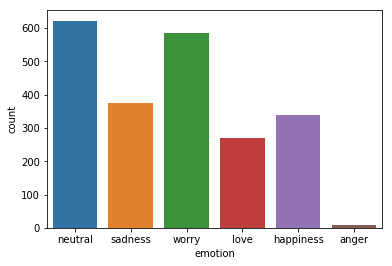

In [13]:
sns.countplot(train['emotion'])

In [14]:
mapping_target = {'neutral':0, 'worry':1, 'sadness':2, 'happiness':3, 'love':4, 'anger':5}
train = train.replace({'emotion':mapping_target})
target = train['emotion']
test_reviews = test['review']

In [15]:
# function to clean data
import string
import itertools 
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

#stop_words = set(stopwords.words('english'))
### Non-negative stop words.
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between',
 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same',
 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'should', 'now', 'd', 'll', 'm', 'o', 're',
 've', 'y', 'ma']

def cleanData(text, lowercase = False, remove_stops = False, stemming = False, lemmatization = False):
    txt = str(text)
    
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'d", " would")
    txt = txt.replace("'ll", " will")
    txt = txt.replace("--th", " ")
    
    # More cleaning
    txt = re.sub(r"alot", "a lot", txt)
    txt = re.sub(r"what's", "", txt)
    txt = re.sub(r"What's", "", txt)
    
    
    # Remove urls and emails
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', txt, flags=re.MULTILINE)
    txt = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', txt, flags=re.MULTILINE)
    
    # Replace words like sooooooo with so
    txt = ''.join(''.join(s)[:2] for _, s in itertools.groupby(txt))
    
    # Remove punctuation from text
    txt = ''.join([c for c in text if c not in punctuation])
    
    # Remove all symbols
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
        
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])

    return txt

In [16]:
pos_emoji = [':-)', ':)', ':-]', ':]', ':-3', ':3', ':->', ':>', '8-)', '8)', ':-}', ':}', ':o)', ':c)', ':^)', '=]', '=)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=D', '=3', 'B^D', ':-))', ';-)', ';)', '*-)', '*)', ';-]', ';]', ';^)', ';D', ':-P', ':P', 'X-P', 'x-p', ':-p', ':p', ':-?', ':?', ':-?', ':?', ':-b', ':b', '=p', '>:P', ':*', ':-*', '^.^', '^_^', '^-^', 'xd']
neg_emoji = [':-(', ':(', ':-c', ':c', ':-<', ':<', ':-[', ':[', ':-||', '>:[', ':{', ':@', '>:(', ':-/', ':/', '>:\\', '>:/', ':\\', '=/', '=\\', ':L', '=L', ':S', ':-|', ':|', ':-X', ':X', '-.-', '-,-']

In [17]:
## Number of positive emoji in the text ##
train["number_of_positive_emo"] = train['review'].apply(lambda x: len([c for c in str(x).split() if c in pos_emoji]))
test["number_of_positive_emo"] = test['review'].apply(lambda x: len([c for c in str(x).split() if c in pos_emoji]))

## Number of negative emoji in the text ##
train["number_of_negative_emo"] = train['review'].apply(lambda x: len([c for c in str(x).split() if c in neg_emoji]))
test["number_of_negative_emo"] = test['review'].apply(lambda x: len([c for c in str(x).split() if c in neg_emoji]))

train["num_words"] = train["review"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["review"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["review"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["review"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["review"].apply(lambda x: len(str(x)))
test["num_chars"] = test["review"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test["num_stopwords"] = test["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [18]:
cleaned_train = train.copy()
cleaned_test = test.copy()
# clean comments
cleaned_train['review'] = train['review'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True, lemmatization = True))
cleaned_test['review'] = test['review'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True, lemmatization = True))

In [19]:
cleaned_test['emotion'] = np.nan
alldata = pd.concat([cleaned_train, cleaned_test]).reset_index(drop=True)

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [49]:
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,3),min_df = 10,max_df=0.8, sublinear_tf=True,
                             use_idf=True)
tfidfdata = tfidfvec.fit_transform(alldata['review'])

In [50]:
# create dataframe for features
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [51]:
tfidf_df.columns = ['col' + str(x) for x in tfidf_df.columns]

In [52]:
tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

In [53]:
# split the merged data file into train and test respectively
train_feats = alldata[~pd.isnull(alldata.emotion)]
test_feats = alldata[pd.isnull(alldata.emotion)]

In [54]:
# merge into a new data frame with tf-idf features
cols = ['number_of_positive_emo','number_of_negative_emo','num_words','num_unique_words','num_chars','num_stopwords','num_punctuations','num_words_upper','num_words_title','mean_word_len']
train_feats2 = pd.concat([train_feats[cols], tfid_df_train], axis=1)
test_feats2 = pd.concat([test_feats[cols], tfid_df_test], axis=1)

In [61]:
### Upsampling to balance the classes

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_feats2, train['emotion'].ravel())

In [72]:
np.bincount(y_train_res)

array([622, 622, 622, 622, 622, 622])

# Model

In [73]:
### Using Random Forest we got highest validation score. Accuracy can be increased using ensembling techniques.

In [116]:
model = RandomForestClassifier()#LogisticRegression(penalty='l2')

In [118]:
## Naive Bayes 2 - tfidf is giving higher CV score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
print(cross_val_score(model, X_train_res, y_train_res, cv=10, scoring=make_scorer(accuracy_score)))

[0.56084656 0.51322751 0.55107527 0.57258065 0.5188172  0.63172043
 0.76612903 0.78763441 0.79032258 0.77150538]


In [119]:
model.fit(train_feats2, train['emotion'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [120]:
pred = model.predict(test_feats2)

In [121]:
result = pd.DataFrame()
result['review'] = test_reviews
result['emotion'] = pred
mapping = {0:'neutral', 1:'worry', 2:'sadness', 3:'happiness', 4:'love', 5:'anger'}
result = result.replace({'emotion':mapping})

result.to_csv("tf_idf_result.csv", index=False)

In [122]:
result.head()

,review,emotion
0,@gfalcone601 that little girl on BGT! how sad!...,sadness
1,Today I wrote two songs (one for temple which ...,worry
2,Have 3 of the 5 grandbabies again today. 19 mo...,love
3,on my way to driver's training,neutral
4,"@rmolden Yes, maybe, but for today, I write",neutral


## Using Deep learning

In [136]:
MAX_SEQUENCE_LENGTH = 140
MAX_NB_WORDS = 5000

In [137]:
tokenizer = Tokenizer(lower=False, filters='',num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(train['review'])

sequences = tokenizer.texts_to_sequences(train['review'])
test_sequences = tokenizer.texts_to_sequences(test['review'])

train_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of train data tensor:', train_data.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

nb_words = (np.max(train_data) + 1)

Shape of train data tensor: (2200, 400)


In [138]:
from keras.layers.recurrent import LSTM, GRU
model = Sequential()
model.add(Embedding(nb_words,100,input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 400, 100)          894400    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 400, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 1,012,422
Trainable params: 1,012,422
Non-trainable params: 0
_________________________________________________________________


In [139]:
model.fit(train_data, train['emotion'].values, validation_split=0.2, nb_epoch=25, batch_size=32, callbacks=[EarlyStopping(patience=2)])

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 1760 samples, validate on 440 samples
Epoch 1/25
1760/1760 [==============================] - 50s 28ms/step - loss: 1.6314 - acc: 0.2773 - val_loss: 1.5835 - val_acc: 0.2750
Epoch 2/25
1760/1760 [==============================] - 46s 26ms/step - loss: 1.5836 - acc: 0.2841 - val_loss: 1.5783 - val_acc: 0.2750
Epoch 3/25
1760/1760 [==============================] - 44s 25ms/step - loss: 1.5717 - acc: 0.2869 - val_loss: 1.5780 - val_acc: 0.2750
Epoch 4/25
1760/1760 [==============================] - 42s 24ms/step - loss: 1.4801 - acc: 0.2989 - val_loss: 1.5367 - val_acc: 0.3136
Epoch 5/25
1760/1760 [==============================] - 45s 26ms/step - loss: 1.1115 - acc: 0.5074 - val_loss: 1.7058 - val_acc: 0.2682
Epoch 6/25
1760/1760 [==============================] - 43s 24ms/step - loss: 0.7186 - acc: 0.7364 - val_loss: 1.8903 - val_acc: 0.2773


In [143]:
pred = model.predict(test_data)
pred

array([[0.03176159, 0.04356652, 0.25882858, 0.02311728, 0.00376215,
        0.00202857],
       [0.0138741 , 0.00340667, 0.00944322, 0.46270207, 0.5968051 ,
        0.00388942],
       [0.05287918, 0.03730596, 0.06956759, 0.04091349, 0.01069351,
        0.00145889],
       ...,
       [0.21452421, 0.07213514, 0.04195243, 0.0144422 , 0.00363017,
        0.00207085],
       [0.6165208 , 0.04831154, 0.02218549, 0.01699293, 0.03509303,
        0.00465251],
       [0.04521891, 0.11928763, 0.03079759, 0.02609345, 0.00087572,
        0.00076186]], dtype=float32)

In [145]:
pred_list = []
for p in pred:
    mn,idx = max((p[i],i) for i in range(len(p)))
    pred_list.append(idx)

In [146]:
result = pd.DataFrame()
result['review'] = test_reviews
result['emotion'] = pred_list
mapping = {0:'neutral', 1:'worry', 2:'sadness', 3:'happiness', 4:'love', 5:'anger'}
result = result.replace({'emotion':mapping})

result.to_csv("nn_result.csv", index=False)

In [147]:
result.head()

,review,emotion
0,@gfalcone601 that little girl on BGT! how sad!...,sadness
1,Today I wrote two songs (one for temple which ...,love
2,Have 3 of the 5 grandbabies again today. 19 mo...,sadness
3,on my way to driver's training,neutral
4,"@rmolden Yes, maybe, but for today, I write",worry


In [123]:
result['emotion'].value_counts()

neutral      419
worry        290
sadness      100
love          83
happiness     51
Name: emotion, dtype: int64